In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer  # type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences  # type: ignore
import re
import string
from tqdm import tqdm
import numpy as np
import os 
import gensim
from gensim.models import KeyedVectors
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import GaussianNB, MultinomialNB
import sklearn.metrics as metrics
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import text_dataset_from_directory   # type: ignore
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

# ƒê·ªçc DATA v√† ki·ªÉm tra ƒë·ªô l·ªách c·ªßa DATA 

In [2]:
path_train = "DATA/data_train/data_train/train"
path_val = "DATA/data_train/data_train/test"
path_test = "DATA/data_test/data_test/test"


train_df = text_dataset_from_directory(path_train,
                                     batch_size=64,
                                     shuffle=True,
                                     seed=123)

val_df = text_dataset_from_directory(path_val,
                                   batch_size=64,
                                   shuffle=False,
                                   seed=123)

test_df = text_dataset_from_directory(path_test,
                                    batch_size=64,
                                    shuffle=False,
                                    seed=123)


print(train_df.class_names, val_df.class_names, test_df.class_names)
print(len(train_df), len(val_df), len(test_df))

Found 30000 files belonging to 2 classes.
Found 10000 files belonging to 2 classes.
Found 10000 files belonging to 2 classes.
['neg', 'pos'] ['neg', 'pos'] ['neg', 'pos']
469 157 157


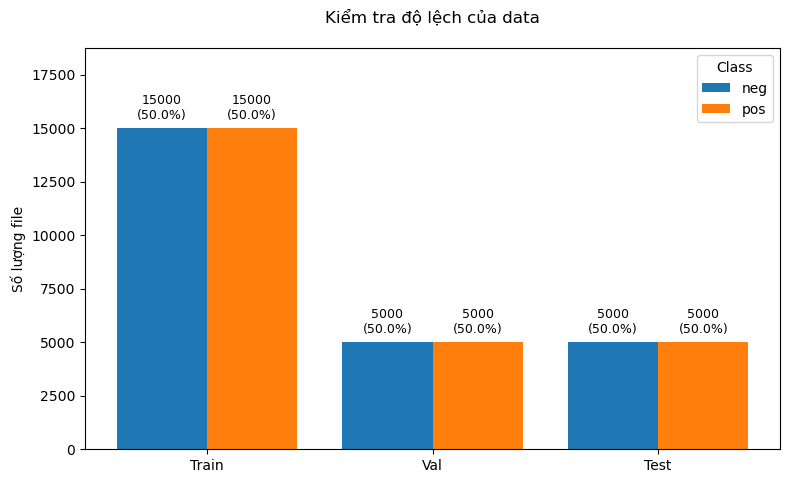

In [3]:
def plot_split_grouped_by_class(base_dir,
                                train_name="train",
                                val_name="test",
                                test_name="test",
                                ext_filter=('.txt',)):
    base = Path(base_dir)
    train_dir = base / "data_train" / "data_train" / train_name
    val_dir   = base / "data_train" / "data_train" / val_name
    test_dir  = base / "data_test"  / "data_test"  / test_name

    def discover_classes(*dirs):
        classes = set()
        for d in dirs:
            if d.exists() and d.is_dir():
                for p in d.iterdir():
                    if p.is_dir():
                        classes.add(p.name)
        ordered = []
        for c in ('neg', 'pos', 'negative', 'positive'):
            if c in classes:
                ordered.append(c)
        # th√™m c√°c l·ªõp c√≤n l·∫°i
        for c in sorted(classes):
            if c not in ordered:
                ordered.append(c)
        return ordered

    classes = discover_classes(train_dir, val_dir, test_dir)
    if len(classes) == 0:
        print("Kh√¥ng t√¨m th·∫•y l·ªõp (class) n√†o. Ki·ªÉm tra ƒë∆∞·ªùng d·∫´n.")
        return

    def count_in_dir(dir_path, cls):
        p = Path(dir_path) / cls
        if not p.exists():
            return 0
        if ext_filter is None:
            return sum(1 for _ in p.rglob('*') if _.is_file() and not _.name.startswith('.'))
        else:
            return sum(1 for _ in p.rglob('*') if _.is_file() and _.suffix.lower() in ext_filter and not _.name.startswith('.'))

    splits_dirs = [("Train", train_dir), ("Val", val_dir), ("Test", test_dir)]
    counts = []
    for name, d in splits_dirs:
        row = [count_in_dir(d, c) for c in classes]
        counts.append(row)
    counts = np.array(counts)  

    split_totals = counts.sum(axis=1)

    n_splits = counts.shape[0]
    n_classes = counts.shape[1]
    x = np.arange(n_splits)
    width = 0.8 / max(1, n_classes)

    fig, ax = plt.subplots(figsize=(8, 5))
    bars = []
    for j in range(n_classes):
        offsets = x - 0.4 + (j + 0.5) * width
        b = ax.bar(offsets, counts[:, j], width, label=classes[j])
        bars.append(b)

    max_height = int(counts.max() if counts.size else 0)
    top_margin_factor = 1.25
    ax.set_ylim(0, max(1, int(max_height * top_margin_factor)))

    for j, bset in enumerate(bars):
        for i, bar in enumerate(bset):
            h = int(bar.get_height())
            total = split_totals[i]
            pct = (h / total * 100.0) if total > 0 else 0.0
            offset = max(1, int(max_height * 0.02))
            ax.text(bar.get_x() + bar.get_width()/2., h + offset,
                    f"{h}\n({pct:.1f}%)",
                    ha='center', va='bottom', fontsize=9)

    ax.set_xticks(x)
    ax.set_xticklabels([s for s, _ in splits_dirs])
    ax.set_ylabel("S·ªë l∆∞·ª£ng file")
    ax.set_title("Ki·ªÉm tra ƒë·ªô l·ªách c·ªßa data", pad=18)
    ax.legend(title="Class")
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

plot_split_grouped_by_class("DATA")


In [4]:
import random
path_0 = 'DATA/data_train/data_train/train'
path_1 = random.choice(os.listdir(path_0))
path_2 = random.randint(0, len(train_df)*32)
path_3 = '.txt'

path = path_0 + '/' + path_1 + '/' + str(path_2) + path_3
print(path)

if os.path.exists(path):
    with open(path, "r", encoding="utf-8") as f:
        lines = f.readlines()
    print(lines[0])
else:
    print("File kh√¥ng t·ªìn t·∫°i:", path)

DATA/data_train/data_train/train/neg/1536.txt
m√¨nh ƒÉn ƒë∆∞·ª£c m·ªôt th·ªùi_gian l√¢u , gi·ªù m·ªõi fb , nh∆∞ng c√≥ g√¨ ƒë·∫•y sai sai . H√¥m ƒëi ƒë·∫øn ƒë√∫ng ƒë·ªãa_ch·ªâ r·ªìi th√¨ th·∫•y h√†ng n√†y , v√†o g·ªçi ƒë·ªì th√¨ nh√¨n hoa kh√¥ng c√≥ thanh_long ƒë·ªè T . T m√°c nh√¨n c≈©n kh√¥ng ph·∫£i lak lak , b∆° h√¥m ƒë·∫•y h∆°i ƒë·∫Øng , ch√¢n tr√¢u c·ª©ng , hoa_qu·∫£ nh·∫°t ,



In [5]:
df = pd.read_csv('DATA/Tweets.csv')
df.sample(5)

tweet_id airline_sentiment  airline_sentiment_confidence  \
10265  569429468781150208          negative                         1.000   
10239  569467550100267008          negative                         1.000   
4333   570304178314190848          negative                         1.000   
12755  570036187815149570          negative                         0.657   
980    569979211722596353          negative                         1.000   

                negativereason  negativereason_confidence     airline  \
10265   Customer Service Issue                     1.0000  US Airways   
10239  Flight Booking Problems                     0.6540  US Airways   
4333                Bad Flight                     0.6784   Southwest   
12755               Bad Flight                     0.3548    American   
980                 Can't Tell                     0.6804      United   

      airline_sentiment_gold           name negativereason_gold  \
10265                    NaN        pmj1234                 NaN   
10239                    NaN        jednell                 NaN   
4333                     NaN   tonybrancato                 NaN   
12755                    NaN        rkaradi                 NaN   
980                      NaN  CoffeeCult448                 NaN   

       retweet_count                                               text  \
10265              0  @USAirways on hold for 2 hours now have been c...   
10239              0  @USAirways OK, I guess the weather has been ro...   
4333               0  @SouthwestAir my wife had been in group A in p...   
12755              0  @AmericanAir ok makes no sense tho Since you'l...   
980                0                 @united I think DM would be better   

                      tweet_coord              tweet_created  \
10265                         NaN  2015-02-22 01:32:19 -0800   
10239                         NaN  2015-02-22 04:03:38 -0800   
4333   [41.1974934, -73.76920486]  2015-02-24 11:28:06 -0800   
12755                         NaN  2015-02-23 17:43:12 -0800   
980                           NaN  2015-02-23 13:56:48 -0800   

                     tweet_location               user_timezone  
10265                           NaN                         NaN  
10239                           NaN                         NaN  
4333                   Chappaqua NY  Eastern Time (US & Canada)  
12755                           NaN                         NaN  
980    Buffalo/Oakland/Savannah/Ire                         NaN

In [6]:
df['airline_sentiment'].value_counts(),len(df)

(airline_sentiment
 negative    9178
 neutral     3099
 positive    2363
 Name: count, dtype: int64,
 14640)

# X·ª≠ l√Ω c√°c k√Ω t·ª± trong c√¢u

In [7]:
from pyvi import ViTokenizer, ViPosTagger

text = "T√¥i ƒëang h·ªçc x·ª≠ l√Ω ng√¥n ng·ªØ t·ª± nhi√™n"
ViTokenizer.tokenize(text)

'T√¥i ƒëang h·ªçc x·ª≠_l√Ω ng√¥n_ng·ªØ t·ª±_nhi√™n'

In [8]:
import re
import string
from pyvi import ViTokenizer

# Regex ƒë·ªÉ lo·∫°i b·ªè emoji (c√°c k√Ω t·ª± m·∫∑t c∆∞·ªùi, bi·ªÉu t∆∞·ª£ng c·∫£m x√∫c...)
emoji_pattern = re.compile("[" 
                u"\U0001F600-\U0001F64F"  # emoticons (m·∫∑t c∆∞·ªùi)
                u"\U0001F300-\U0001F5FF"  # bi·ªÉu t∆∞·ª£ng & h√¨nh v·∫Ω
                u"\U0001F680-\U0001F6FF"  # ph∆∞∆°ng ti·ªán & b·∫£n ƒë·ªì
                u"\U0001F1E0-\U0001F1FF"  # c·ªù qu·ªëc gia
                u"\U00002702-\U000027B0"
                u"\U000024C2-\U0001F251"
                u"\U0001f926-\U0001f937"
                u'\U00010000-\U0010ffff'
                u"\u200d"
                u"\u2640-\u2642"
                u"\u2600-\u2B55"
                u"\u23cf"
                u"\u23e9"
                u"\u231a"
                u"\u3030"
                u"\ufe0f"
    "]+", flags=re.UNICODE)

def clean_text(text):
    # 1. Chuy·ªÉn to√†n b·ªô vƒÉn b·∫£n v·ªÅ ch·ªØ th∆∞·ªùng
    text = text.lower()

    # 2. Lo·∫°i b·ªè emoji
    text = re.sub(emoji_pattern, " ", text)

    # 3. Gi·∫£m b·ªõt c√°c k√Ω t·ª± l·∫∑p l·∫°i li√™n ti·∫øp (vd: "ƒë·∫πpppp" -> "ƒë·∫πp")
    text = re.sub(r'([a-zA-Z√†√°·∫°·∫£√£√¢·∫ß·∫•·∫≠·∫©·∫´ƒÉ·∫±·∫Ø·∫∑·∫≥·∫µ√®√©·∫π·∫ª·∫Ω√™·ªÅ·∫ø·ªá·ªÉ·ªÖ'
                  r'√¨√≠·ªã·ªâƒ©√≤√≥·ªç·ªè√µ√¥·ªì·ªë·ªô·ªï·ªó∆°·ªù·ªõ·ª£·ªü·ª°√π√∫·ª•·ªß≈©∆∞·ª´·ª©·ª±·ª≠·ªØ'
                  r'·ª≥√Ω·ªµ·ª∑·ªπƒë])\1+', r'\1', text)

    # 4. Chu·∫©n h√≥a kho·∫£ng tr·∫Øng quanh d·∫•u c√¢u
    text = re.sub(r"(\w)\s*([" + string.punctuation + "])\s*(\w)", r"\1 \2 \3", text)
    text = re.sub(r"(\w)\s*([" + string.punctuation + "])", r"\1 \2", text)

    # 5. R√∫t g·ªçn c√°c d·∫•u c√¢u l·∫∑p (vd: "!!!" -> "!")
    text = re.sub(f"([{string.punctuation}])([{string.punctuation}])+", r"\1", text)

    # 6. X√≥a d·∫•u c√¢u ·ªü ƒë·∫ßu v√† cu·ªëi chu·ªói
    text = text.strip()
    while text.endswith(tuple(string.punctuation + string.whitespace)):
        text = text[:-1]
    while text.startswith(tuple(string.punctuation + string.whitespace)):
        text = text[1:]

    # 7. Lo·∫°i b·ªè to√†n b·ªô d·∫•u c√¢u c√≤n s√≥t l·∫°i
    text = text.translate(str.maketrans('', '', string.punctuation))

    # 8. Chu·∫©n h√≥a nhi·ªÅu kho·∫£ng tr·∫Øng li√™n ti·∫øp th√†nh 1 kho·∫£ng tr·∫Øng
    text = re.sub(r"\s+", " ", text)

    # 9. T√°ch t·ª´ b·∫±ng Pyvi (gh√©p t·ª´ gh√©p nh∆∞ "x·ª≠ l√Ω" -> "x·ª≠_l√Ω")
    text = ViTokenizer.tokenize(text)

    return text



In [9]:
sample = "·ªêi d·ªìi √¥iiiiii !!!!!!! Tr√¨nh l√† g√¨iiiiiiiiiii ???  R·ªìi tr√¨nh ai ch·∫•mmmmm"
print(clean_text(sample))

·ªëi d·ªìi √¥i tr√¨nh l√† g√¨i r·ªìi tr√¨nh ai ch·∫•m


In [10]:
import pandas as pd
import tensorflow as tf

# H√†m ti·ªán √≠ch: ƒë·ªçc dataset TensorFlow -> text v√† label
def dataset_to_texts_labels(dataset):
    texts = []
    labels = []
    for text_batch, label_batch in dataset:
        for text, label in zip(text_batch.numpy(), label_batch.numpy()):
            texts.append(text.decode("utf-8"))  # chuy·ªÉn t·ª´ bytes -> string
            labels.append(label)
    return texts, labels

# --- X·ª≠ l√Ω train ---
train_texts, train_labels = dataset_to_texts_labels(train_df)
train_texts = [clean_text(t) for t in train_texts]

# --- X·ª≠ l√Ω val ---
val_texts, val_labels = dataset_to_texts_labels(val_df)
val_texts = [clean_text(t) for t in val_texts]

# --- X·ª≠ l√Ω test ---
test_texts, test_labels = dataset_to_texts_labels(test_df)
test_texts = [clean_text(t) for t in test_texts]

train_df_clean = pd.DataFrame({"text": train_texts, "label": train_labels})
val_df_clean   = pd.DataFrame({"text": val_texts, "label": val_labels})
test_df_clean  = pd.DataFrame({"text": test_texts, "label": test_labels})

print(train_df_clean.sample(5))
print(val_df_clean.sample(5))
print(test_df_clean.sample(5))


                                                    text  label
21414  tu·∫ßn tr∆∞·ªõc ·ªü tr∆∞·ªùng m√¨nh c√≥ t·ªï_ch·ª©c v·ªÅ y_t·∫ø ·ªü ...      1
12934  ƒë·ªì ƒÉn_kh√¥ng ngon ƒë·∫≠u chi√™n qu√° m·ªÅm m√† m√¨nh hay...      0
10776  m√¨nh m·ªõi ƒëi du_l·ªãch ·ªü ƒë√¢y v·ªõi √¥ng_x√£ v·ªÅ ph·∫£i n...      1
19589  t√¨nh_c·ªù t√¨m ƒëu·ª£c qu√°n tr√™n g th·∫•y m·ªçi ng cmt k...      0
15641  m√≥n ƒÉn kh√° t∆∞∆°i tuy_nhi√™n m√¨nh ƒë·∫øn ngo√†i m·ª±c r...      0
                                                   text  label
8467  h√¥m b·ªØa m·ªìng 3 t·∫øt sumo bq khai_tr∆∞∆°ng l·∫°i g·ªçi...      1
5106         10h r·ªìi m√† kh√°ch v·∫´n c√≤n ∆∞u_√°i d thanks_al      1
5421  c·ª≠a_h√†ng n√†y nghe nhi·ªÅu ng∆∞·ªùi b·∫£o ƒÉn ngon ch·∫•t...      1
490   qu√°n c√¥ n∆∞∆°ng n√†y ƒë√£ c√≥ l√¢u r·ªìi t·ª´ c√°i h·ªìi m√¨n...      0
3064  tr∆∞·ªõc ƒë√¢y ph·ªü vina l√† 1 l·ª±a_ch·ªçn y√™u th√≠ch c·ªßa...      0
                                                   text  label
6380  ƒë√¢y l√† 1 trong nh

# M√£ h√≥a sang d·∫°ng ma tr·∫≠n

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer  # type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences  # type: ignore
from tensorflow.keras.utils import to_categorical  # type: ignore

def encode_texts_with_tokenizer(train_texts, val_texts, test_texts,
                                train_labels, val_labels, test_labels,
                                num_words=20000, maxlen=100):
    """
    Encode vƒÉn b·∫£n sang ma tr·∫≠n s·ªë b·∫±ng TensorFlow Tokenizer.
    - num_words: s·ªë t·ª´ t·ªëi ƒëa gi·ªØ l·∫°i trong vocab (theo t·∫ßn su·∫•t).
    - maxlen: ƒë·ªô d√†i chu·ªói c·ªë ƒë·ªãnh sau khi pad/truncate.
    """
    # Kh·ªüi t·∫°o Tokenizer
    tokenizer = Tokenizer(num_words=num_words, oov_token="<UNK>")
    tokenizer.fit_on_texts(train_texts)

    # Bi·∫øn vƒÉn b·∫£n -> sequence s·ªë nguy√™n
    X_train_seq = tokenizer.texts_to_sequences(train_texts)
    X_val_seq   = tokenizer.texts_to_sequences(val_texts)
    X_test_seq  = tokenizer.texts_to_sequences(test_texts)

    # Pad/truncate ƒë·ªÉ c√≥ c√πng ƒë·ªô d√†i
    X_train = pad_sequences(X_train_seq, maxlen=maxlen, padding='post', truncating='post')
    X_val   = pad_sequences(X_val_seq, maxlen=maxlen, padding='post', truncating='post')
    X_test  = pad_sequences(X_test_seq, maxlen=maxlen, padding='post', truncating='post')

    # Labels chuy·ªÉn v·ªÅ numpy array (n·∫øu c·∫ßn)
    y_train = tf.convert_to_tensor(train_labels, dtype=tf.int32)
    y_val   = tf.convert_to_tensor(val_labels, dtype=tf.int32)
    y_test  = tf.convert_to_tensor(test_labels, dtype=tf.int32)

    return X_train, y_train, X_val, y_val, X_test, y_test, tokenizer


In [12]:
len(train_texts)

30000

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
vectorizer = TfidfVectorizer()

vectorizer.fit(train_texts)
X_train_tfidf = vectorizer.transform(train_texts)
X_test_tfidf = vectorizer.transform(test_texts)
X_val_tfidf = vectorizer.transform(val_texts)

X_train_tfidf[:1], X_test_tfidf[:1],X_train_tfidf.shape, X_test_tfidf.shape, X_val_tfidf.shape


(<1x31584 sparse matrix of type '<class 'numpy.float64'>'
 	with 103 stored elements in Compressed Sparse Row format>,
 <1x31584 sparse matrix of type '<class 'numpy.float64'>'
 	with 100 stored elements in Compressed Sparse Row format>,
 (30000, 31584),
 (10000, 31584),
 (10000, 31584))

In [14]:
X_train_tfidf.getnnz()

1771789

In [15]:
feature_names = vectorizer.get_feature_names_out()

first_row = X_train_tfidf[0].toarray()

tfidf_features = pd.DataFrame(first_row, columns=feature_names)

non_zero_features = tfidf_features.loc[:, (tfidf_features != 0).any(axis=0)]
print(non_zero_features)

       bi·∫øt      bu·ªïi       b√£i       b√™n      b∆∞·ªõc       b·∫°n    b·∫£o_v·ªá  \
0  0.059526  0.076413  0.119264  0.186728  0.089402  0.096242  0.102276   

   b·∫•n_lo·∫°n      cafe   chia_s·∫ª  ...        xe  y√™u_s√°ch        ƒëi      ƒë√°ng  \
0  0.198559  0.083683  0.136488  ...  0.127326  0.188625  0.121653  0.082421   

        ƒë√¢y        ƒë√£      ƒë∆∞·ª£c       ƒë·∫øn        ƒë·ªì        ·ªïn  
0  0.075935  0.054463  0.128537  0.045259  0.046293  0.071152  

[1 rows x 103 columns]


In [16]:
X_train, y_train, X_val, y_val, X_test, y_test, tokenizer = encode_texts_with_tokenizer(
    train_df_clean["text"].tolist(),
    val_df_clean["text"].tolist(),
    test_df_clean["text"].tolist(),
    train_df_clean["label"].tolist(),
    val_df_clean["label"].tolist(),
    test_df_clean["label"].tolist(),
    num_words=20000,
    maxlen=128   # t√πy b·∫°n ch·ªçn
)

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("Vocab size:", len(tokenizer.word_index))


X_train shape: (30000, 128)
X_val shape: (10000, 128)
X_test shape: (10000, 128)
Vocab size: 20409


In [17]:
len(train_df.class_names)

2

In [18]:
train_class = to_categorical(train_labels, num_classes=len(train_df.class_names))
val_class = to_categorical(val_labels, num_classes=len(train_df.class_names))
test_class = to_categorical(test_labels, num_classes=len(train_df.class_names))
print(train_class.shape, train_class[:5])
print(val_class.shape, val_class[:5])
print(test_class.shape, test_class[:5])

(30000, 2) [[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
(10000, 2) [[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
(10000, 2) [[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


# Deep learning

## Kh·ªüi t·∫°o m·∫°ng n∆°-ron

In [19]:
from tensorflow.keras.models import Sequential  # type: ignore
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, GlobalMaxPooling1D, Dropout , BatchNormalization, Flatten # type: ignore
from tensorflow.keras.optimizers import Adam, RMSprop, SGD , Adamax, AdamW  # type: ignore
from tensorflow.keras import backend as K  # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau  # type: ignore

In [20]:
# K.clear_session()
# deep_model = Sequential()

# # T·∫ßng Embedding ƒë·∫ßu ti√™n v√¨ ta ƒëang l√†m vi·ªác v·ªõi d·ªØ li·ªáu vƒÉn b·∫£n
# deep_model.add(Embedding(input_dim=20000, output_dim=128, input_length=128))

# # C√°c t·∫ßng LSTM hai chi·ªÅu ƒë·ªÉ h·ªçc chu·ªói t·ªët h∆°n
# deep_model.add(Bidirectional(LSTM(64, return_sequences=True)))
# deep_model.add(BatchNormalization())
# deep_model.add(Dropout(0.3))

# deep_model.add(Bidirectional(LSTM(32)))
# deep_model.add(BatchNormalization())
# deep_model.add(Dropout(0.3))

# # C√°c t·∫ßng Dense cho ph√¢n lo·∫°i
# deep_model.add(Dense(128, activation='relu'))
# deep_model.add(BatchNormalization())
# deep_model.add(Dropout(0.3))

# deep_model.add(Dense(64, activation='relu'))
# deep_model.add(BatchNormalization())
# deep_model.add(Dropout(0.3))

# deep_model.add(Dense(1, activation='sigmoid'))

# deep_model.compile(optimizer=Adamax(learning_rate=1e-3),
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

# deep_model.summary()

In [21]:
from tensorflow.keras.regularizers import l2  # type: ignore
deep_model = Sequential()

deep_model.add(Dense(512, activation='relu', input_shape=(X_train_tfidf.shape[1],)))
deep_model.add(BatchNormalization())
deep_model.add(Dropout(0.3))

deep_model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
deep_model.add(BatchNormalization())
deep_model.add(Dropout(0.3))

deep_model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
deep_model.add(BatchNormalization())
deep_model.add(Dropout(0.3))

deep_model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
deep_model.add(BatchNormalization())
deep_model.add(Dropout(0.3))

deep_model.add(Dense(1, activation='sigmoid'))

deep_model.compile(optimizer=Adamax(learning_rate=1e-2,
                                   beta_1=0.9, # c√≥ t√°c d·ª•ng tƒÉng t·ªëc ƒë·ªô h·ªôi t·ª•
                                   beta_2=0.999, # c√≥ t√°c d·ª•ng c·∫£i thi·ªán ƒë·ªô ch√≠nh x√°c
                                   epsilon=1e-07), # c√≥ t√°c d·ª•ng ·ªïn ƒë·ªãnh h√≥a
              loss='binary_crossentropy',
              metrics=['accuracy'])

deep_model.summary()

Model: "sequential"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ dense (Dense)                   ‚îÇ (None, 512)            ‚îÇ    16,171,520 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization             ‚îÇ (None, 512)            ‚îÇ         2,048 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout (Dropout)               ‚îÇ (None, 512)            ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_1 (Dense)                 ‚îÇ (None, 256)            ‚îÇ       131,328 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_1           ‚îÇ (None, 256)            ‚îÇ         1,024 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_1 (Dropout)             ‚îÇ (None, 256)            ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_2 (Dense)                 ‚îÇ (None, 128)            ‚îÇ        32,896 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_2           ‚îÇ (None, 128)            ‚îÇ           512 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_2 (Dropout)             ‚îÇ (None, 128)            ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_3 (Dense)                 ‚îÇ (None, 64)             ‚îÇ         8,256 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_3           ‚îÇ (None, 64)            

 Total params: 16,347,905 (62.36 MB)

 Trainable params: 16,345,985 (62.35 MB)

 Non-trainable params: 1,920 (7.50 KB)

## hu·∫•n luy·ªán model

In [22]:
train_class = train_labels
val_class = val_labels
test_class = test_labels

train_class = tf.convert_to_tensor(train_class, dtype=tf.float32)
val_class = tf.convert_to_tensor(val_class, dtype=tf.float32)
test_class = tf.convert_to_tensor(test_class, dtype=tf.float32)

In [23]:

stop = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    mode ='min',
    verbose=1
)

save = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1,
)

lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=8,
    min_lr=1e-8,
    verbose=1
)

his = deep_model.fit(X_train_tfidf,
               train_class,
               epochs=20,
               validation_data=(X_val_tfidf, val_class),
               callbacks=[save, lr, stop],
               steps_per_epoch=len(train_df_clean) // 64,
               verbose=1,
               shuffle=True)

Epoch 1/20
462/468 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 75ms/step - accuracy: 0.8184 - loss: 2.4620
Epoch 1: val_loss improved from inf to 0.49431, saving model to best_model.h5


468/468 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 40s 80ms/step - accuracy: 0.8188 - loss: 2.4454 - val_accuracy: 0.8536 - val_loss: 0.4943 - learning_rate: 0.0100
Epoch 2/20
462/468 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 76ms/step - accuracy: 0.9084 - loss: 0.3246
Epoch 2: val_loss improved from 0.49431 to 0.43497, saving model to best_model.h5


468/468 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 38s 80ms/step - accuracy: 0.9083 - loss: 0.3248 - val_accuracy: 0.8718 - val_loss: 0.4350 - learning_rate: 0.0100
Epoch 3/20
462/468 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 77ms/step - accuracy: 0.9267 - loss: 0.3013
Epoch 3: val_loss improved from 0.43497 to 0.42441, saving model to best_model.h5


468/468 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 38s 82ms/step - accuracy: 0.9266 - loss: 0.3014 - val_accuracy: 0.8636 - val_loss: 0.4244 - learning_rate: 0.0100
Epoch 4/20
462/468 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 79ms/step - accuracy: 0.9351 - loss: 0.2677
Epoch 4: val_loss improved from 0.42441 to 0.41688, saving model to best_model.h5


468/468 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 39s 84ms/step - accuracy: 0.9351 - loss: 0.2678 - val_accuracy: 0.8748 - val_loss: 0.4169 - learning_rate: 0.0100
Epoch 5/20
462/468 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 78ms/step - accuracy: 0.9513 - loss: 0.2249
Epoch 5: val_loss did not improve from 0.41688
468/468 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 38s 82ms/step - accuracy: 0.9513 - loss: 0.2250 - val_accuracy: 0.8629 - val_loss: 0.5633 - learning_rate: 0.0100
Epoch 6/20
462/468 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 77ms/step - accuracy: 0.9619 - loss: 0.2130
Epoch 6: val_loss did not improve from 0.41688
468/468 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 38s 81ms/step - accuracy: 0.9619 - loss: 0.2129 - val_accuracy: 0.8600 - val_loss: 0.5873 - learning_rate: 0.0100
Epoch 7/20
462/468 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 77ms/step - accuracy

In [24]:
text = 'qu√°n n√†y ph·ª•c v·ª• nhi·ªát t√¨nh ƒë·∫øn m·ª©c s·ª£ lu√¥n , kh√°ch n√≥i t√≠ th√¨ ch·ª≠i ƒë√°nh lu√¥n , s·ª£ qu√°'
def xu_ly(text):
    text = clean_text(text)
    text = vectorizer.transform([text])
    return text

text = xu_ly(text)
kq = deep_model.predict(text)
if kq[0][0] > 0.5:
    print('Comment n√†y ƒë∆∞·ª£c ph√¢n lo·∫°i l√†: T√≠ch c·ª±c')
    confidence = kq[0][0] * 100
else:
    print('Comment n√†y ƒë∆∞·ª£c ph√¢n lo·∫°i l√†: Ti√™u c·ª±c')
    confidence = (1 - kq[0][0]) * 100
print("ƒê·ªô tin c·∫≠y:", f"{confidence:.2f}%")

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 154ms/step
Comment n√†y ƒë∆∞·ª£c ph√¢n lo·∫°i l√†: T√≠ch c·ª±c
ƒê·ªô tin c·∫≠y: 63.88%


In [25]:
pd.DataFrame(his.history)

accuracy      loss  val_accuracy  val_loss  learning_rate
0   0.849400  1.168344        0.8536  0.494313          0.010
1   0.903467  0.339796        0.8718  0.434974          0.010
2   0.920133  0.310331        0.8636  0.424409          0.010
3   0.933167  0.272033        0.8748  0.416881          0.010
4   0.948667  0.237353        0.8629  0.563266          0.010
5   0.961367  0.209643        0.8600  0.587330          0.010
6   0.969833  0.184304        0.8612  0.498258          0.010
7   0.975167  0.162634        0.8553  0.538726          0.010
8   0.979233  0.140633        0.8671  0.567501          0.010
9   0.981667  0.138563        0.8665  0.573238          0.010
10  0.984400  0.126829        0.8634  0.540375          0.010
11  0.985700  0.114751        0.8642  0.709764          0.010
12  0.992700  0.073126        0.8678  0.512687          0.001
13  0.995667  0.040478        0.8692  0.548744          0.001
14  0.996733  0.027692        0.8717  0.647410          0.001
15  0.996633  0.022668        0.8706  0.694698          0.001
16  0.997300  0.018965        0.8682  0.669067          0.001
17  0.997833  0.016618        0.8713  0.668292          0.001
18  0.997733  0.015806        0.8696  0.811124          0.001
19  0.998000  0.014704        0.8675  0.791363          0.001

ƒê·ªô ch√≠nh x√°c c·ªßa m√¥ h√¨nh tr√™n t·∫≠p hu·∫•n luy·ªán: 99.80%
ƒê·ªô ch√≠nh x√°c c·ªßa m√¥ h√¨nh tr√™n t·∫≠p ki·ªÉm tra val: 86.75%


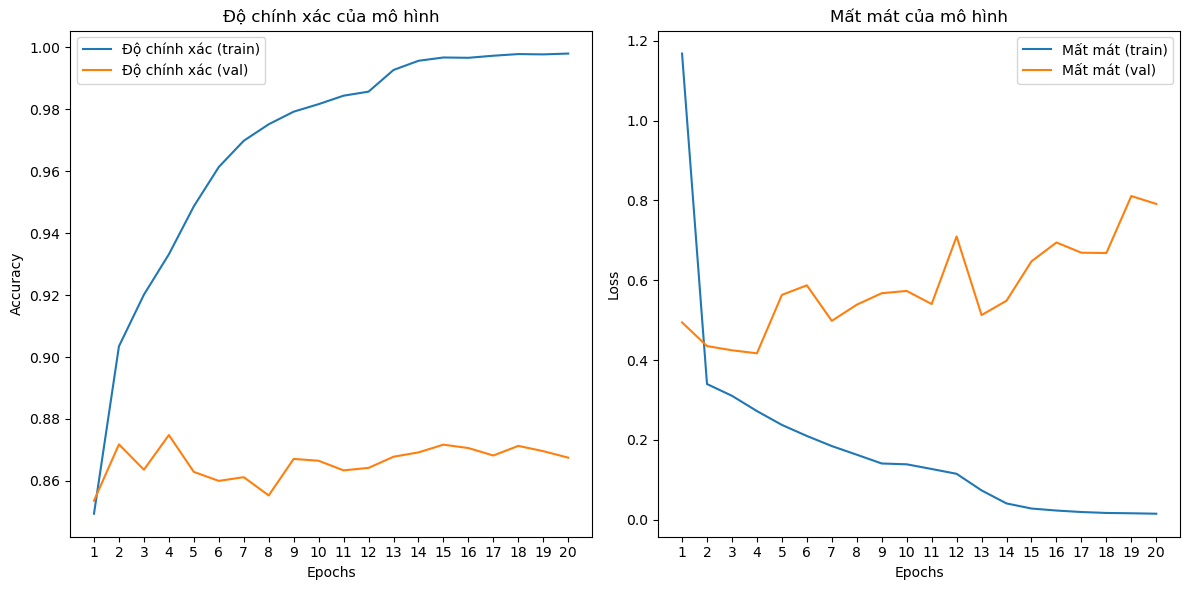

In [26]:
# ƒê·ªô ch√≠nh x√°c c·ªßa m√¥ h√¨nh
print(f"ƒê·ªô ch√≠nh x√°c c·ªßa m√¥ h√¨nh tr√™n t·∫≠p hu·∫•n luy·ªán: {his.history['accuracy'][-1] * 100:.2f}%")
print(f"ƒê·ªô ch√≠nh x√°c c·ªßa m√¥ h√¨nh tr√™n t·∫≠p ki·ªÉm tra val: {his.history['val_accuracy'][-1] * 100:.2f}%")

epochs = range(1, len(his.history['accuracy']) + 1)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, his.history['accuracy'], label='ƒê·ªô ch√≠nh x√°c (train)')
plt.plot(epochs, his.history['val_accuracy'], label='ƒê·ªô ch√≠nh x√°c (val)')
plt.title('ƒê·ªô ch√≠nh x√°c c·ªßa m√¥ h√¨nh')
plt.xlabel('Epochs')
plt.xticks(epochs)
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs, his.history['loss'], label='M·∫•t m√°t (train)')
plt.plot(epochs, his.history['val_loss'], label='M·∫•t m√°t (val)')    
plt.title('M·∫•t m√°t c·ªßa m√¥ h√¨nh')
plt.xlabel('Epochs')
plt.xticks(epochs)
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()


313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 7ms/step
ƒê·ªô ch√≠nh x√°c c·ªßa model: 87.73%


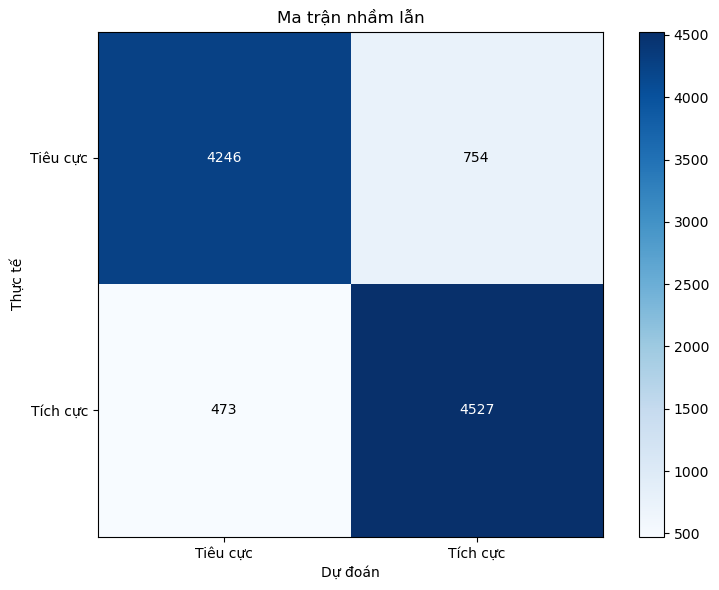

In [27]:
# v·∫Ω ma tr·∫≠n nh·∫ßm l·∫´n
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.models import load_model  # type: ignore

model = load_model('best_model.h5')

yred = deep_model.predict(X_test_tfidf)
yred = (yred > 0.5).astype(int)

# ƒë·ªô ch√≠nh x√°c tr√™n t·∫≠p ki·ªÉm tra
acc_test = accuracy_score(y_test, yred)
print(f"ƒê·ªô ch√≠nh x√°c c·ªßa model: {acc_test* 100:.2f}%")

cm = confusion_matrix(y_test, yred)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Ma tr·∫≠n nh·∫ßm l·∫´n')
plt.colorbar()

# Th√™m s·ªë li·ªáu v√†o c√°c √¥
thresh = cm.max() / 2
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             ha="center", va="center",
             color="white" if cm[i, j] > thresh else "black")

# Ch·ªâ c·∫ßn ƒë·ªãnh nghƒ©a labels m·ªôt l·∫ßn
labels = ['Ti√™u c·ª±c', 'T√≠ch c·ª±c']
plt.xticks([0, 1], labels)
plt.yticks([0, 1], labels)

plt.xlabel('D·ª± ƒëo√°n')
plt.ylabel('Th·ª±c t·∫ø')
plt.tight_layout()
plt.show()

# Machine learning

In [28]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

machine_deep = SVC(C=1,
                   class_weight= None,
                   gamma='scale',
                   kernel='rbf'
                   )
machine_deep.fit(X_train_tfidf, 
                 train_labels)
print('ƒê·ªô ch√≠nh x√°c c·ªßa model tr√™n t·∫≠p train:', machine_deep.score(X_train_tfidf, train_labels))
print('ƒê·ªô ch√≠nh x√°c c·ªßa model tr√™n t·∫≠p validation:', machine_deep.score(X_val_tfidf, val_labels))
kq_test = machine_deep.predict(X_test_tfidf)
acc_test = accuracy_score(test_labels, kq_test)
print('ƒê·ªô ch√≠nh x√°c c·ªßa model tr√™n t·∫≠p test:', acc_test)


ƒê·ªô ch√≠nh x√°c c·ªßa model tr√™n t·∫≠p train: 0.9736666666666667
ƒê·ªô ch√≠nh x√°c c·ªßa model tr√™n t·∫≠p validation: 0.8862
ƒê·ªô ch√≠nh x√°c c·ªßa model tr√™n t·∫≠p test: 0.8944


In [29]:
kq_test = machine_deep.predict(X_val_tfidf)
acc_test = accuracy_score(val_labels, kq_test)
print('ƒê·ªô ch√≠nh x√°c c·ªßa model tr√™n t·∫≠p validation:', acc_test)

ƒê·ªô ch√≠nh x√°c c·ªßa model tr√™n t·∫≠p validation: 0.8862


ƒê·ªô ch√≠nh x√°c c·ªßa model: 88.62%


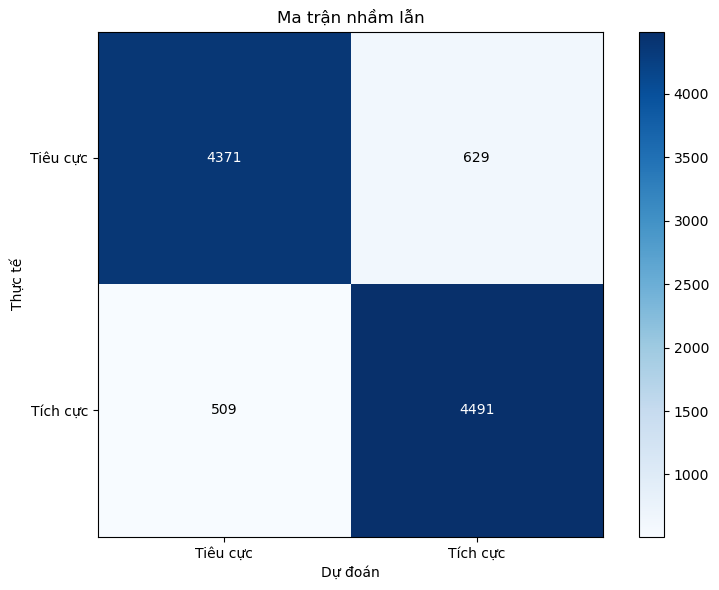

In [30]:
acc_test = accuracy_score(y_test, kq_test)
print(f"ƒê·ªô ch√≠nh x√°c c·ªßa model: {acc_test* 100:.2f}%")

cm = confusion_matrix(y_test, kq_test)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Ma tr·∫≠n nh·∫ßm l·∫´n')
plt.colorbar()

# Th√™m s·ªë li·ªáu v√†o c√°c √¥
thresh = cm.max() / 2
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             ha="center", va="center",
             color="white" if cm[i, j] > thresh else "black")

# Ch·ªâ c·∫ßn ƒë·ªãnh nghƒ©a labels m·ªôt l·∫ßn
labels = ['Ti√™u c·ª±c', 'T√≠ch c·ª±c']
plt.xticks([0, 1], labels)
plt.yticks([0, 1], labels)

plt.xlabel('D·ª± ƒëo√°n')
plt.ylabel('Th·ª±c t·∫ø')
plt.tight_layout()
plt.show()

In [31]:
import joblib

joblib.dump(machine_deep, 'MODEL/machine_deep.sav')

['MODEL/machine_deep.sav']

In [32]:
from tensorflow.keras.models import load_model  # type: ignore
import joblib

model1 = load_model('MODEL/deep(Nh·∫≠n di·ªán t·ªët nh·∫•t)IF-IDF.h5')
model2 = joblib.load('MODEL/machine_deep.sav')
a = input('Nh·∫≠p comment c·ªßa b·∫°n: ')
print('Comment ban ƒë·∫ßu:',a)
a = clean_text(a)
print('Comment sau khi x·ª≠ l√Ω:',a)

# a = tokenizer.texts_to_sequences([a])
# print('Comment sau khi chuy·ªÉn ƒë·ªïi th√†nh chu·ªói:', a)
# # Pad sequence to match training data length
# a = pad_sequences(a, maxlen=100, padding='post', truncating='post')
# print('Comment sau khi padding:', a)

a = vectorizer.transform([a])
print('Comment sau khi chuy·ªÉn ƒë·ªïi th√†nh ma tr·∫≠n TF-IDF:', a.toarray())

pred = model1.predict(a)
if pred[0][0] > 0.5:
    print('Comment n√†y ƒë∆∞·ª£c ph√¢n lo·∫°i l√†: T√≠ch c·ª±c')
    confidence = pred[0][0] * 100
else:
    print('Comment n√†y ƒë∆∞·ª£c ph√¢n lo·∫°i l√†: Ti√™u c·ª±c')
    confidence = (1 - pred[0][0]) * 100
print("ƒê·ªô tin c·∫≠y:", f"{confidence:.2f}%")

kq_test = model2.predict(a)
if kq_test[0] == 1:
    print('Comment n√†y ƒë∆∞·ª£c ph√¢n lo·∫°i l√†: T√≠ch c·ª±c')
else:
    print('Comment n√†y ƒë∆∞·ª£c ph√¢n lo·∫°i l√†: Ti√™u c·ª±c')

Comment ban ƒë·∫ßu: qu√°n n√†y ph·ª•c v·ª• nhi·ªát t√¨nh ƒë·∫øn m·ª©c s·ª£ lu√¥n , kh√°ch n√≥i t√≠ th√¨ ch·ª≠i ƒë√°nh lu√¥n , s·ª£ 
Comment sau khi x·ª≠ l√Ω: qu√°n n√†y ph·ª•c_v·ª• nhi·ªát_t√¨nh ƒë·∫øn m·ª©c s·ª£ lu√¥n kh√°ch n√≥i t√≠ th√¨ ch·ª≠i ƒë√°nh lu√¥n s·ª£
Comment sau khi chuy·ªÉn ƒë·ªïi th√†nh ma tr·∫≠n TF-IDF: [[0. 0. 0. ... 0. 0. 0.]]
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 148ms/step
Comment n√†y ƒë∆∞·ª£c ph√¢n lo·∫°i l√†: Ti√™u c·ª±c
ƒê·ªô tin c·∫≠y: 77.81%
Comment n√†y ƒë∆∞·ª£c ph√¢n lo·∫°i l√†: T√≠ch c·ª±c


# Test model

### C√¢u ch√™:
"Th·∫≠t s·ª± th·∫•t v·ªçng v·ªõi nh√† h√†ng n√†y khi m·ªçi th·ª© t·ª´ d·ªãch v·ª• ƒë·∫øn ch·∫•t l∆∞·ª£ng m√≥n ƒÉn ƒë·ªÅu kh√¥ng ƒë·∫°t k·ª≥ v·ªçng. Kh√¥ng gian qu√°n tuy r·ªông r√£i nh∆∞ng l·∫°i thi·∫øu s·ª± chƒÉm ch√∫t, b√†n gh·∫ø s·∫Øp x·∫øp l·ªôn x·ªôn v√† kh√¥ng s·∫°ch s·∫Ω. M√≥n ƒÉn th√¨ nh·∫°t nh·∫Ωo, kh√¥ng c√≥ g√¨ ƒë·∫∑c s·∫Øc, th·∫≠m ch√≠ m·ªôt s·ªë m√≥n c√≤n c√≥ c·∫£m gi√°c kh√¥ng t∆∞∆°i m·ªõi. Nh√¢n vi√™n ph·ª•c v·ª• thi·∫øu chuy√™n nghi·ªáp, th√°i ƒë·ªô kh√¥ng th√¢n thi·ªán v√† th·ªùi gian ch·ªù ƒë·ª£i m√≥n qu√° l√¢u. V·ªõi m·ª©c gi√° cao nh∆∞ v·∫≠y, t√¥i nghƒ© r·∫±ng nh√† h√†ng c·∫ßn c·∫£i thi·ªán r·∫•t nhi·ªÅu ƒë·ªÉ x·ª©ng ƒë√°ng v·ªõi s·ª± k·ª≥ v·ªçng c·ªßa kh√°ch h√†ng."

Th·∫≠t s·ª± üòû th·∫•t v·ªçng vs qu√°n n√†y üëâ https://bit.ly/xyz123 ‚Ä¶ m·ªçi th·ª© t·ª´ dv ü•≤ t·ªõi m√≥n ƒÉn ƒë·ªÅu ko ƒë·∫°t üòë. Kh√¥ng gian r·ªông m√† b√†y bi·ªán l·ªôn x·ªôn, b√†n gh·∫ø c√≤n d√≠nh b·∫©n ü§¢. ƒê·ªì ƒÉn th√¨ nh·∫°t to·∫πt, v√†i m√≥n th·∫•y c√≤n ko t∆∞∆°i. Nv th√¨ ki·ªÉu kh√≥ ch·ªãu, g·ªçi 3-4 l·∫ßn m·ªõi ra. ƒê·ª£i d√†i c·∫£ c·ªï ‚è≥. V·ªõi gi√° üí∏ nh∆∞ n√†y th√¨ qu√° ch√°t, ch·∫Øc ch·∫Øn ko quay l·∫°i üëé.

qu√°n n√†y ph·ª•c v·ª• nhi·ªát t√¨nh ƒë·∫øn m·ª©c s·ª£ lu√¥n , kh√°ch n√≥i t√≠ th√¨ ch·ª≠i ƒë√°nh lu√¥n , s·ª£ 

### C√¢u khen:
"Nh√† h√†ng n√†y th·ª±c s·ª± l√† m·ªôt tr·∫£i nghi·ªám ·∫©m th·ª±c ƒë·ªânh cao, t·ª´ c√°ch b√†i tr√≠ kh√¥ng gian sang tr·ªçng, tinh t·∫ø cho ƒë·∫øn h∆∞∆°ng v·ªã m√≥n ƒÉn ƒë∆∞·ª£c ch·∫ø bi·∫øn m·ªôt c√°ch t·ªâ m·ªâ, c·∫ßu k·ª≥. M·ªói m√≥n ƒÉn nh∆∞ m·ªôt t√°c ph·∫©m ngh·ªá thu·∫≠t, kh√¥ng ch·ªâ ngon mi·ªáng m√† c√≤n ƒë·∫πp m·∫Øt, khi·∫øn th·ª±c kh√°ch kh√¥ng th·ªÉ kh√¥ng tr·∫ßm tr·ªì. ƒê·ªôi ng≈© nh√¢n vi√™n ph·ª•c v·ª• chuy√™n nghi·ªáp, lu√¥n ni·ªÅm n·ªü v√† s·∫µn s√†ng ƒë√°p ·ª©ng m·ªçi y√™u c·∫ßu, t·∫°o c·∫£m gi√°c tho·∫£i m√°i v√† d·ªÖ ch·ªãu. ƒê√¢y ch·∫Øc ch·∫Øn l√† m·ªôt ƒë·ªãa ƒëi·ªÉm l√Ω t∆∞·ªüng ƒë·ªÉ th∆∞·ªüng th·ª©c ·∫©m th·ª±c v√† t·∫≠n h∆∞·ªüng nh·ªØng kho·∫£nh kh·∫Øc ƒë√°ng nh·ªõ."

Nh√† h√†ng n√†y ƒë√∫ng l√† tr·∫£i nghi·ªám 5‚≠ê ƒë·ªânh th·∫≠t üòçüëâ https://goo.gl/abc456. Kh√¥ng gian sang x·ªãn m·ªãn ‚ú®, b√†i tr√≠ tinh t·∫ø. M√≥n ƒÉn th√¨ c·ª±c k·ª≥ ngon, tr√¨nh b√†y ƒë·∫πp m·∫Øt nh∆∞ ngh·ªá thu·∫≠t üé®, ƒÉn v·ª´a ngon v·ª´a th√≠ch m·∫Øt. Nv ph·ª•c v·ª• th√¨ si√™u d·ªÖ th∆∞∆°ng üòä, nhi·ªát t√¨nh kh·ªèi ch√™, h·ªèi g√¨ c≈©ng h·ªó tr·ª£ li·ªÅn. ƒêi 1 l·∫ßn l√† m√™, ch·∫Øc ch·∫Øn recommend üëçüî•.
